# Measurement noise assessment

In this notebook, we illustrate how to use pyABC with different noise models. For simplicity, we use a simple ODE model of a conversion reaction. For simplicity, we consider a single parameter:

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyabc

init = sp.array([1, 0])

def f(y, t0, theta1, theta2=np.exp(-2)):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2

theta1_true = np.exp(-2.5)
theta_true = {'theta1': theta1_true}

prior = pyabc.Distribution(
    theta1=pyabc.RV("uniform", 0, 0.2))

measurement_times = sp.arange(10)

We assume that the underlying dynamics of our observations follow the following model:

In [2]:
def model(pars):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(pars["theta1"],))
    return {'X_2': sol[:,1]}

true_trajectory = model(theta_true)

However, we assume that our measurements are subject to additive Gaussian noise:

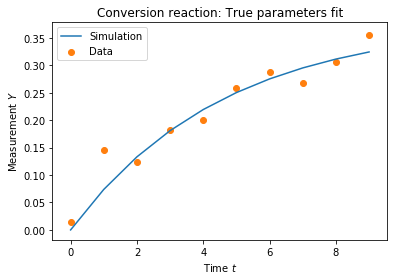

In [3]:
sigma = 0.02

def model_noisy(pars):
    sim = model(pars)
    return {'X_2': sim['X_2'] + sigma * np.random.randn(10)}

measured_data = model_noisy(theta_true)

# plot data
plt.plot(true_trajectory['X_2'], color="C0", label='Simulation')
plt.scatter(measurement_times, measured_data['X_2'],
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: True parameters fit')
plt.legend()
plt.show()

In the notebook "Ordinary Differential Equations: Conversion Reaction", this model is used without accounting for a noise model, which is strictly speaking not correct. In this case, we get the following result:

In [4]:
def distance(simulation, data):
    return sp.absolute(data["X_2"] - simulation["X_2"]).sum()

abc = pyabc.ABCSMC(model, prior, distance)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=231, start_time=2019-11-11 03:27:18.163957, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.9902853202578963
INFO:ABC:t: 0, eps: 0.9902853202578963.
INFO:ABC:Acceptance rate: 100 / 235 = 4.2553e-01.
INFO:ABC:t: 1, eps: 0.4965188759608816.
INFO:ABC:Acceptance rate: 100 / 201 = 4.9751e-01.
INFO:ABC:t: 2, eps: 0.3245983290910613.
INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01.
INFO:ABC:t: 3, eps: 0.2236123291973112.
INFO:ABC:Acceptance rate: 100 / 223 = 4.4843e-01.
INFO:ABC:t: 4, eps: 0.20492135062565608.
INFO:ABC:Acceptance rate: 100 / 208 = 4.8077e-01.
INFO:ABC:t: 5, eps: 0.20153885753140516.
INFO:ABC:Acceptance rate: 100 / 239 = 4.1841e-01.
INFO:ABC:t: 6, eps: 0.2002177308858836.
INFO:ABC:Acceptance rate: 100 / 195 = 5.1282e-01.
INFO:ABC:t: 7, eps: 0.19960587003860417.
INFO:ABC:Acceptance rate: 100 / 217 = 4.6083e-01.
INFO:ABC:t: 8, eps: 0.19932255879573377.
INFO:ABC:Acceptance rate: 100 / 188 = 5.3191e-01.
INFO:

As one can see in the below plot, this converges to a point estimate as $\varepsilon\rightarrow 0$, and does not correctly represent the posterior.

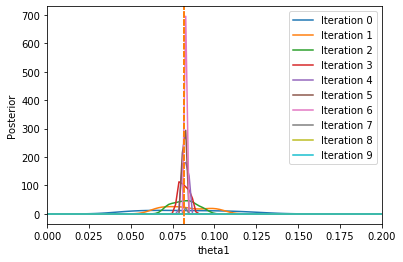

In [5]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="theta1", t=t, refval=theta_true,
        xmin=0, xmax=0.2, numx=100, ax=ax, label=f"Iteration {t}")
ax.legend()

To correctly account for noise, there are essentially two possibilities: Firstly, we can use the noisified model output:

In [6]:
abc = pyabc.ABCSMC(model_noisy, prior, distance)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_noisy_output = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=232, start_time=2019-11-11 03:27:24.825720, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 1.1024059844413174
INFO:ABC:t: 0, eps: 1.1024059844413174.
INFO:ABC:Acceptance rate: 100 / 184 = 5.4348e-01.
INFO:ABC:t: 1, eps: 0.5569939130339638.
INFO:ABC:Acceptance rate: 100 / 223 = 4.4843e-01.
INFO:ABC:t: 2, eps: 0.3465118555408728.
INFO:ABC:Acceptance rate: 100 / 213 = 4.6948e-01.
INFO:ABC:t: 3, eps: 0.2827027665873225.
INFO:ABC:Acceptance rate: 100 / 261 = 3.8314e-01.
INFO:ABC:t: 4, eps: 0.24671331001076252.
INFO:ABC:Acceptance rate: 100 / 457 = 2.1882e-01.
INFO:ABC:t: 5, eps: 0.22466817206119552.
INFO:ABC:Acceptance rate: 100 / 577 = 1.7331e-01.
INFO:ABC:t: 6, eps: 0.20952877032002815.
INFO:ABC:Acceptance rate: 100 / 1117 = 8.9526e-02.
INFO:ABC:t: 7, eps: 0.1926616409577905.
INFO:ABC:Acceptance rate: 100 / 2012 = 4.9702e-02.
INFO:ABC:t: 8, eps: 0.17729419053591058.
INFO:ABC:Acceptance rate: 100 / 3743 = 2.6717e-02.
IN

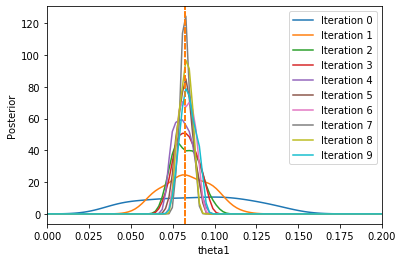

In [7]:
_, ax = plt.subplots()
for t in range(history_noisy_output.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_noisy_output, x="theta1", t=t, refval=theta_true,
        xmin=0, xmax=0.2, ax=ax, numx=100, label=f"Iteration {t}")
ax.legend()

This curve is much broader and, as one can show, closer to the correct posterior.

Secondly, we can alternatively use the non-noisy model, but adjust the acceptance step:

In [8]:
acceptor = pyabc.StochasticAcceptor()
kernel = pyabc.IndependentNormalKernel(var=sigma**2)
eps = pyabc.Temperature()

abc = pyabc.ABCSMC(model, prior, kernel, eps=eps, acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_acceptor = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=233, start_time=2019-11-11 03:27:48.205344, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 98.47851558845545.
INFO:ABC:Acceptance rate: 100 / 282 = 3.5461e-01.
INFO:ABC:t: 1, eps: 6.731417131452395.
INFO:ABC:Acceptance rate: 100 / 348 = 2.8736e-01.
INFO:ABC:t: 2, eps: 1.1617477251373427.
INFO:ABC:Acceptance rate: 100 / 273 = 3.6630e-01.
INFO:ABC:t: 3, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 150 = 6.6667e-01.
INFO:History:Done <ABCSMC(id=233, start_time=2019-11-11 03:27:48.205344, end_time=2019-11-11 03:27:52.338821)>


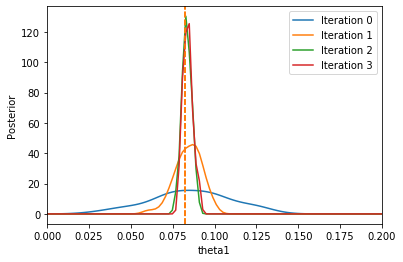

In [9]:
_, ax = plt.subplots()
for t in range(history_acceptor.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_acceptor, x="theta1", t=t, refval=theta_true,
        xmin=0, xmax=0.2, ax=ax, numx=100, label=f"Iteration {t}")
ax.legend()

We see that we get essentially the same posterior distribution as with the noisy output, however at a much lower computational cost, as the below plot shows:

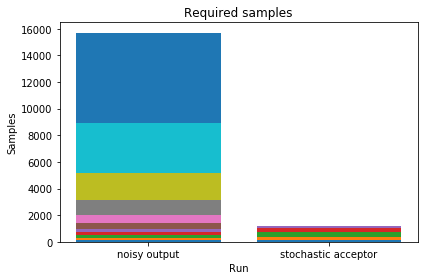

In [10]:
histories = [history_noisy_output, history_acceptor]
labels = ["noisy output", "stochastic acceptor"]

pyabc.visualization.plot_sample_numbers(histories, labels)

Thus, the stochastic acceptor is the proposed method to use in practice. Various noise models and temperature decay schemes are implemented in pyABC. Further details follow.